In [8]:
import os
from pathlib import Path
from mistralai import Mistral
from IPython.core.display import display, Markdown
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
import openai
from dotenv import load_dotenv
import os
import requests

/tmp/ipykernel_2110/2002338400.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, Markdown


In [ ]:
#api_key = userdata.get('Mistral_OCR')
client = Mistral(api_key="")
     

In [3]:
pdf_path="/workspaces/AgenticAI-Systems/RAG/Document/مراسلات.pdf"
uploaded_pdf = client.files.upload(file={"file_name": pdf_path,"content": open(pdf_path, "rb")},purpose="ocr")

In [4]:
client.files.retrieve(file_id=uploaded_pdf.id)


RetrieveFileOut(id='ccb6e294-367d-462a-8818-605f7d4fb272', object='file', size_bytes=4867782, created_at=1742483531, filename='مراسلات.pdf', purpose='ocr', sample_type='ocr_input', source='upload', deleted=False, num_lines=None)

In [5]:
signed_url = client.files.get_signed_url(file_id=uploaded_pdf.id)


In [6]:
ocr_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": signed_url.url,
    },
    include_image_base64=True
)

[OCRPageObject(index=0, markdown='Kuwait Gulf Oil Company (K.G.C)\nA Subsidiary of Kuwait Petroleum Corporation\nA Subsidiary of Kuwait Petroleum Corporation\nA Subsidiary of Kuwait Petroleum Corporation\nالمصطفى\n\n| Date : | التاريخ : 19 سبتمبر 2017 |\n| :--: | :--: |\n| From : |  |\n| To : | رئيس فريق عمل المـدفـوعـات الماليـمـا |\n| Ref. : | رئيس فريق عمل الشؤون القانونيـمـا للمكـتب الرئيسي والتقاضي |\n\nالموضوع : الدعوى رقم 2017/1876 عمالـى كلى / 2\nالمقامت من سالم عبداللّ محمد سالم اليشر (86577) ضد الشـرطة\n\nبالإشارة الى مـذكـرتكم مرجع رقـم TL/HO/330/17 المؤرخـّ في 22 أغسطس 2017 بخصوص\nالموضـوع المذكور أعلاه، نـرفق لكـم نسـخـّ من التسويـح النهائيـّ لمستحقات نهايـّ الخدمـّ والمخالصـّ النهائيـّ ممهورة بتوقيع المدعي.\n\nوتفضلــوا بقبــول فائـق الاحــترام ...\n![img-0.jpeg](img-0.jpeg)\n\nنسخت\n\n- مدير مجموعة الخدمات الماليـث', images=[OCRImageObject(id='img-0.jpeg', top_left_x=236, top_left_y=1335, bottom_right_x=1502, bottom_right_y=1870, image_base64='')], dimensions=OCRPageDime
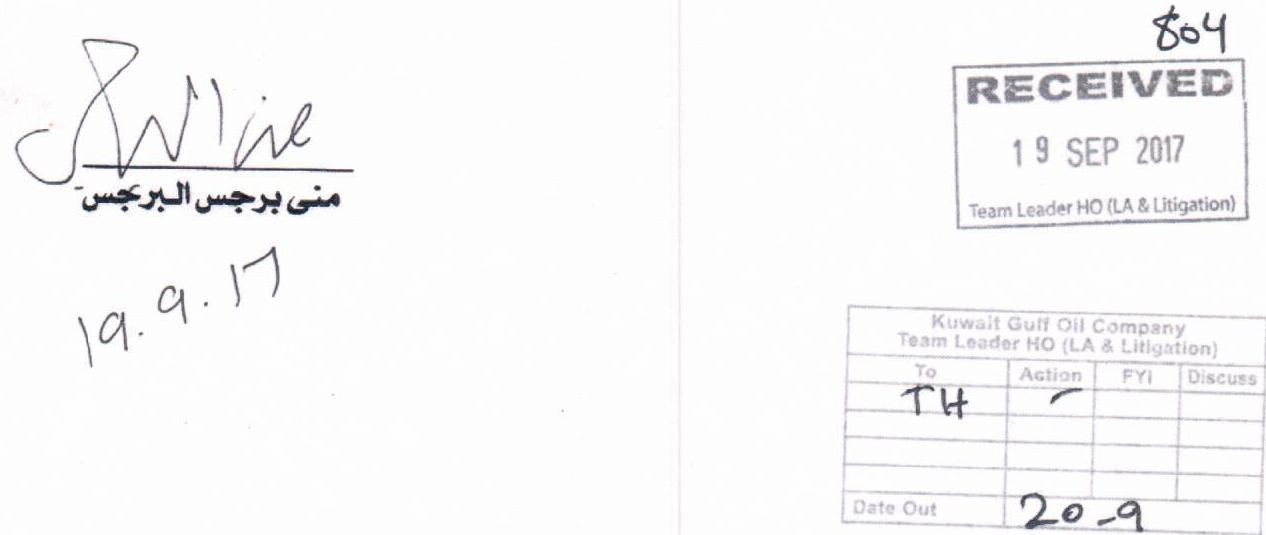
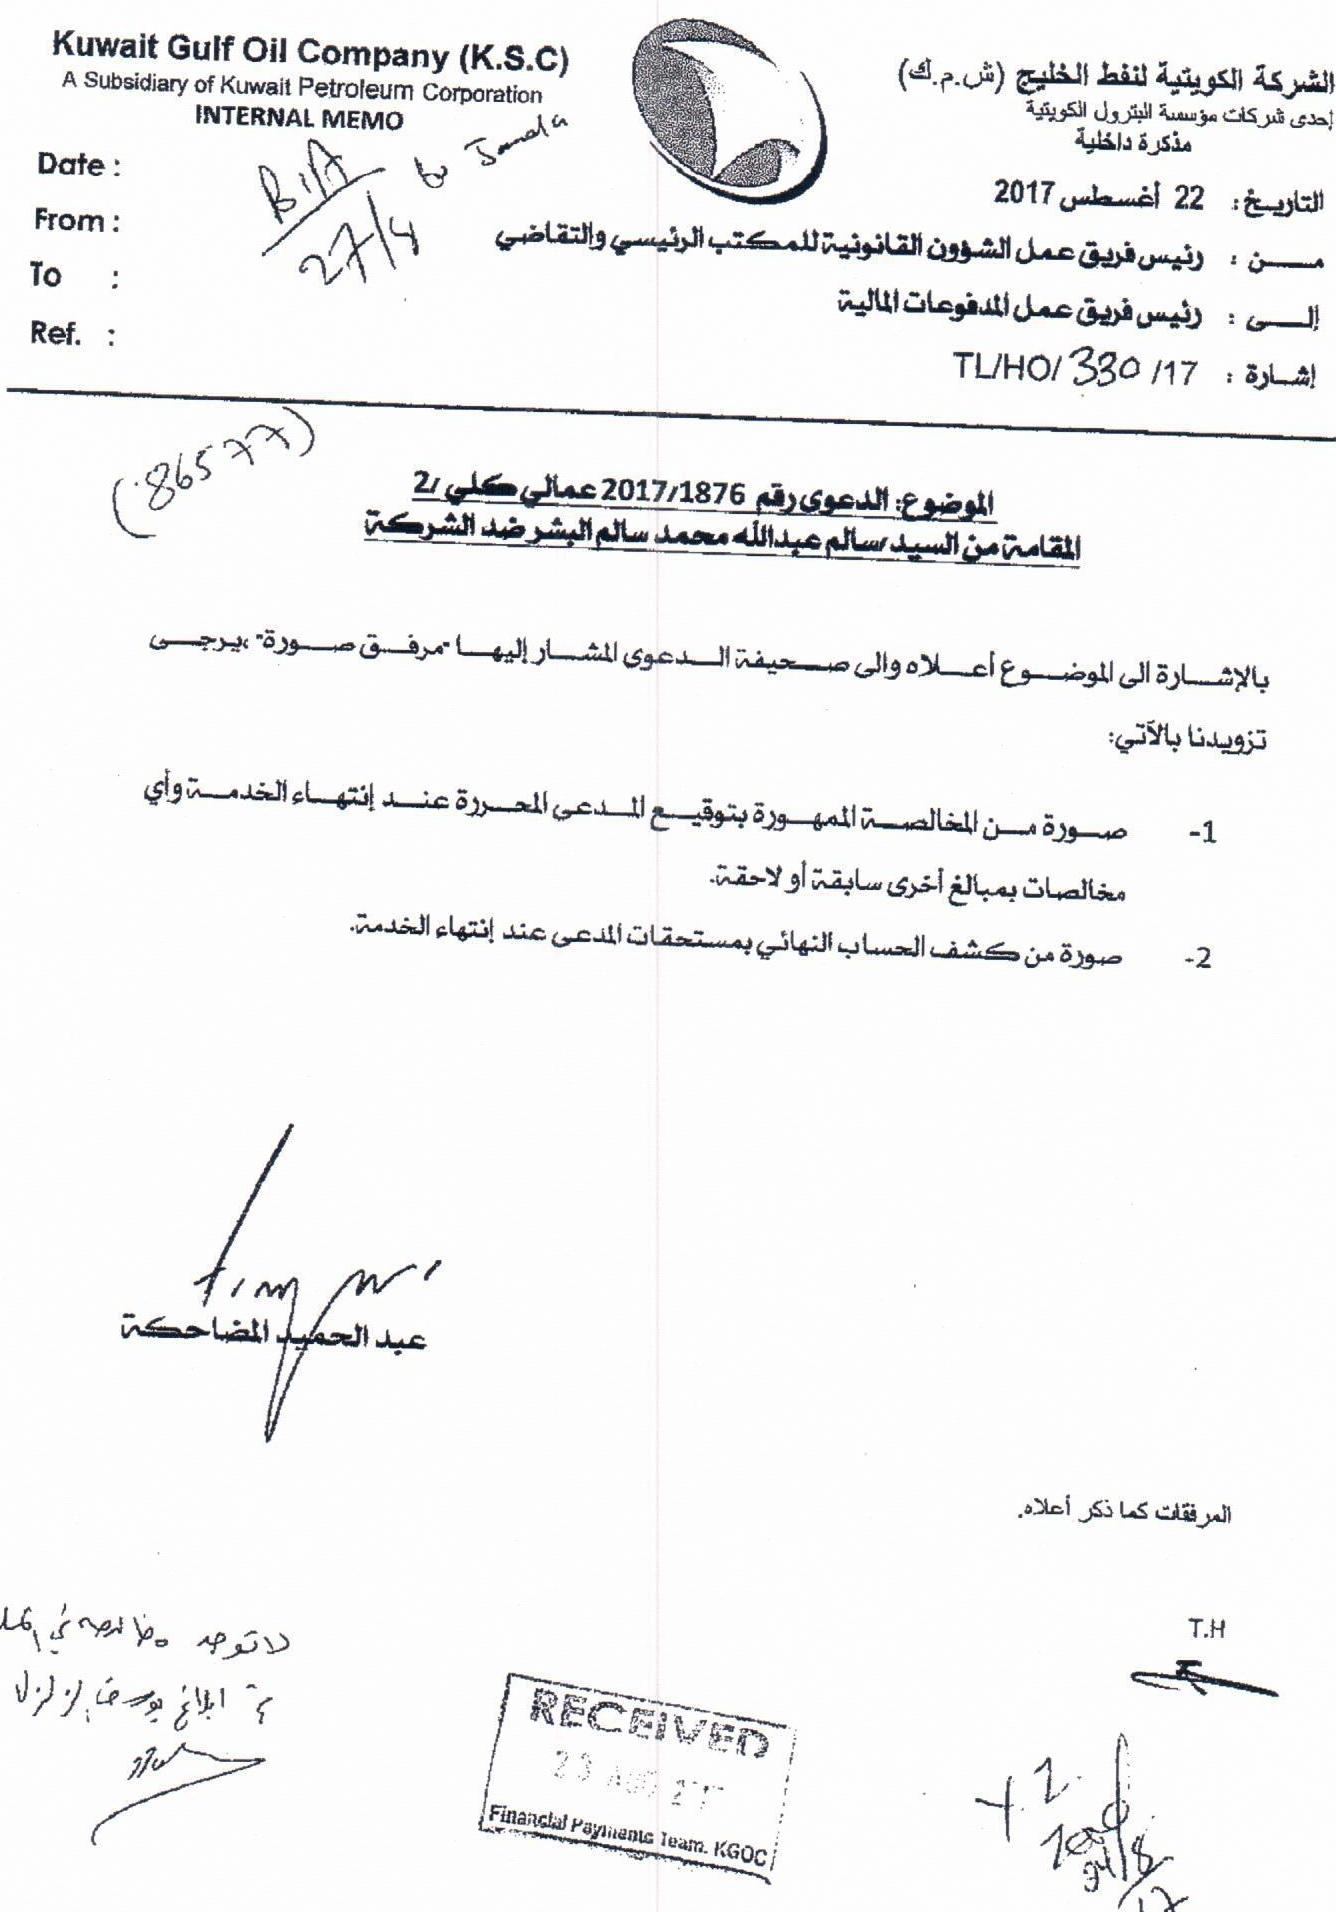
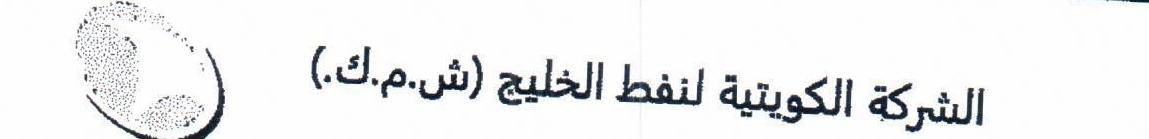
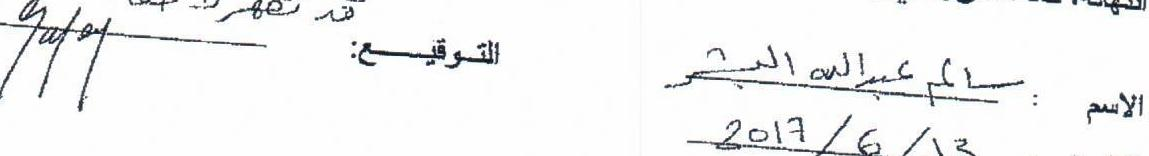
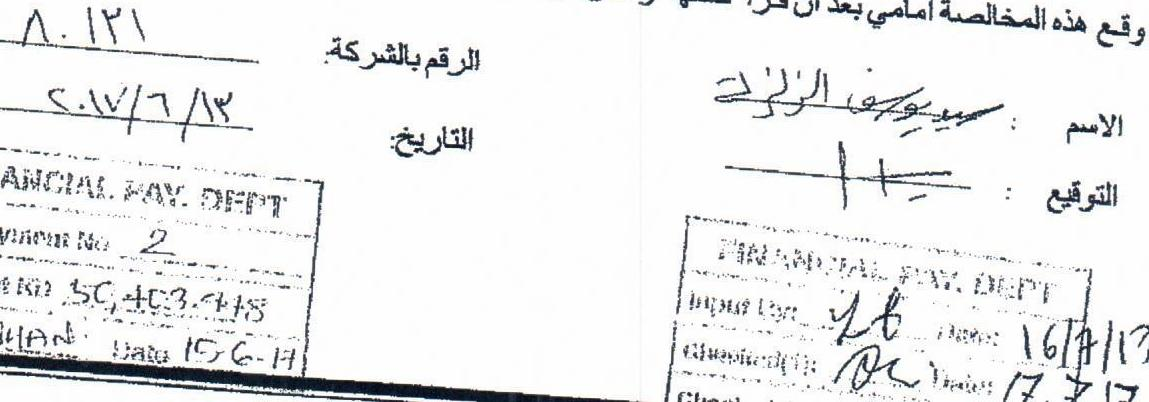
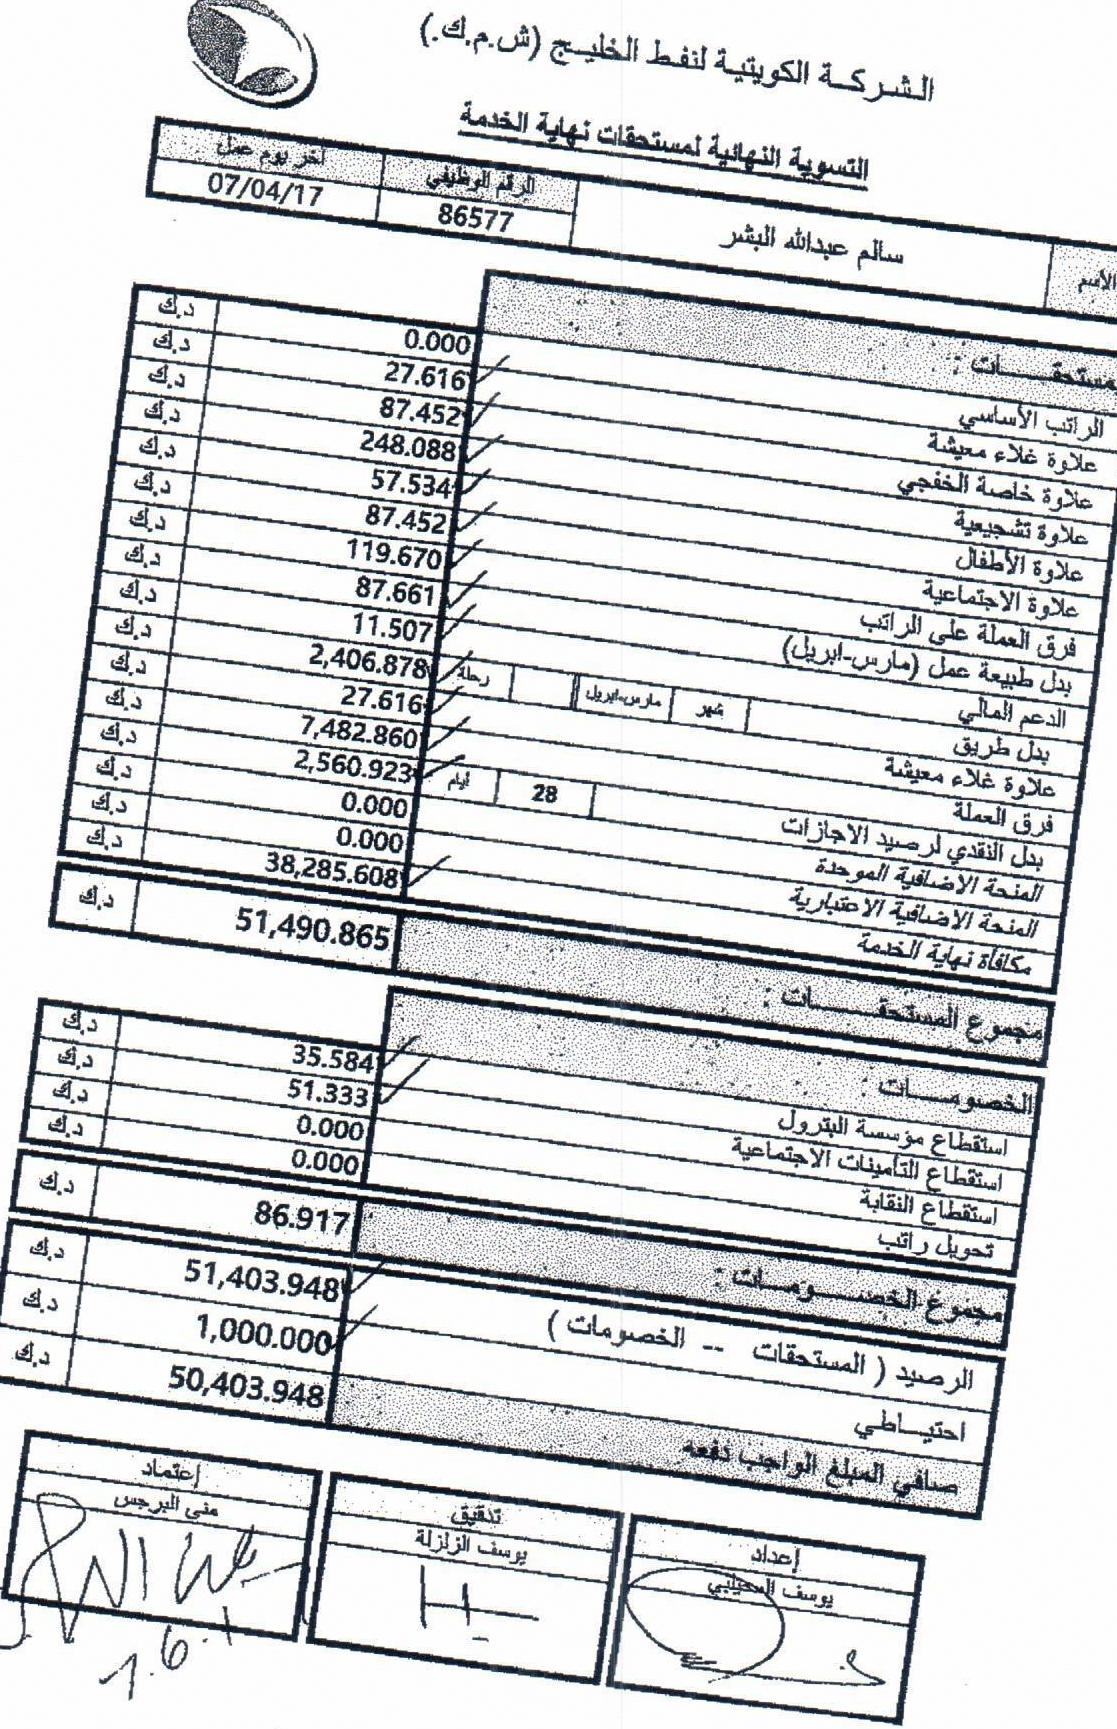
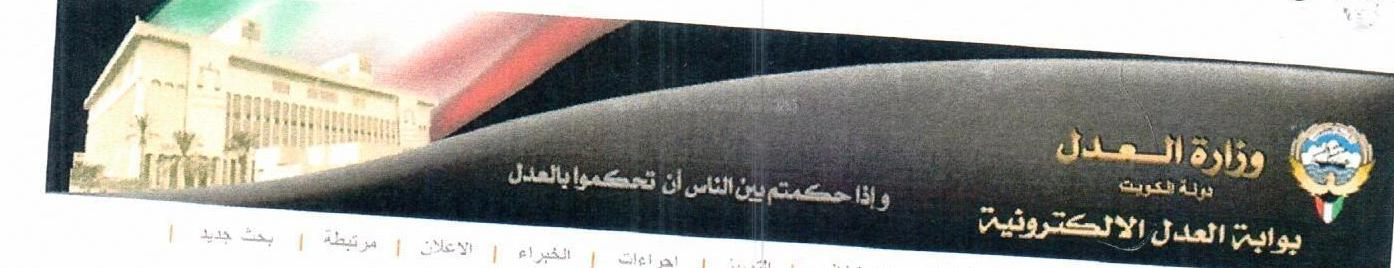
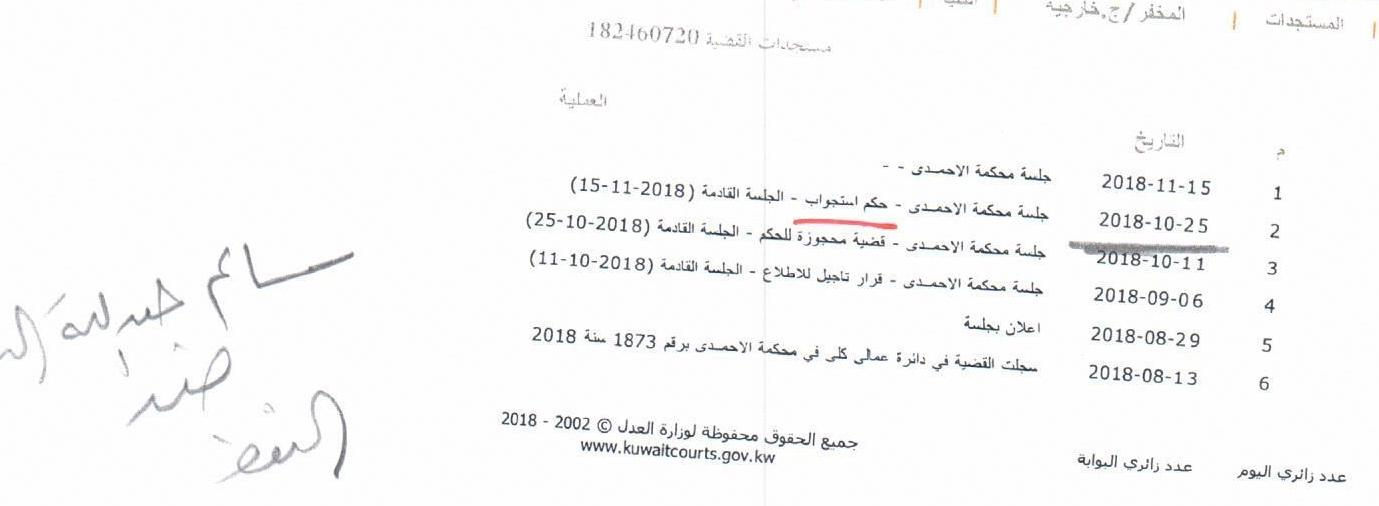
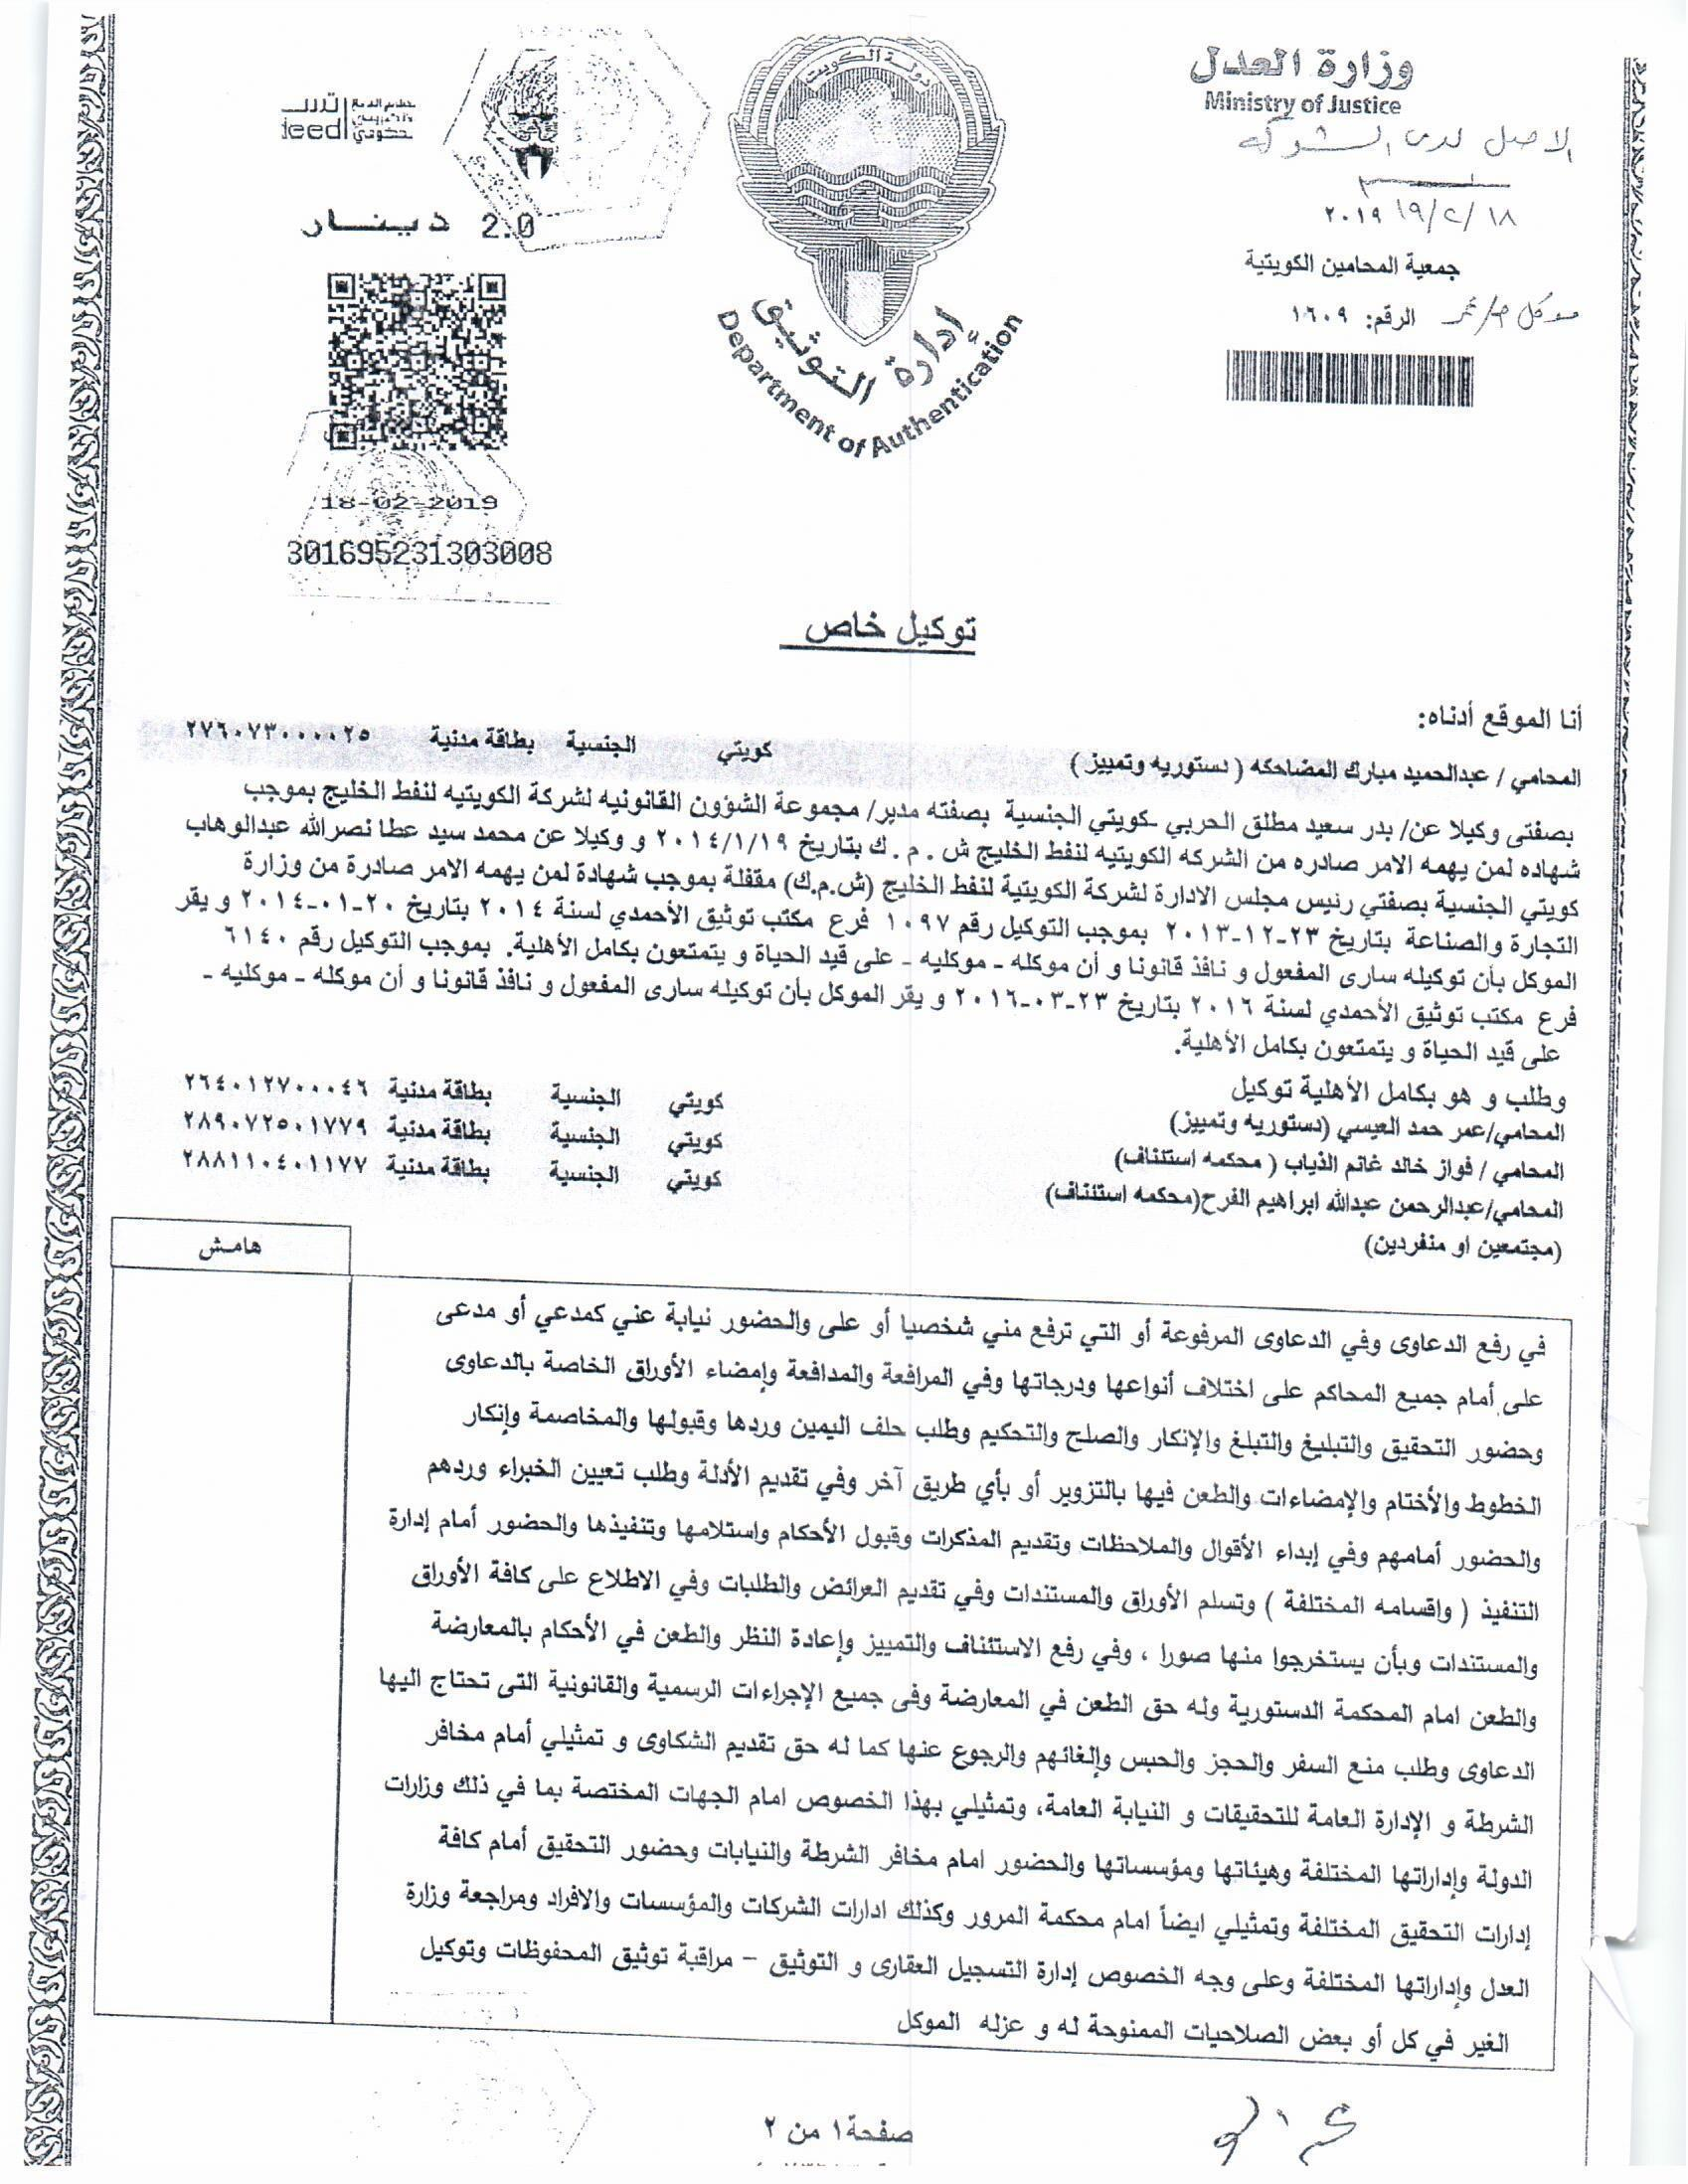
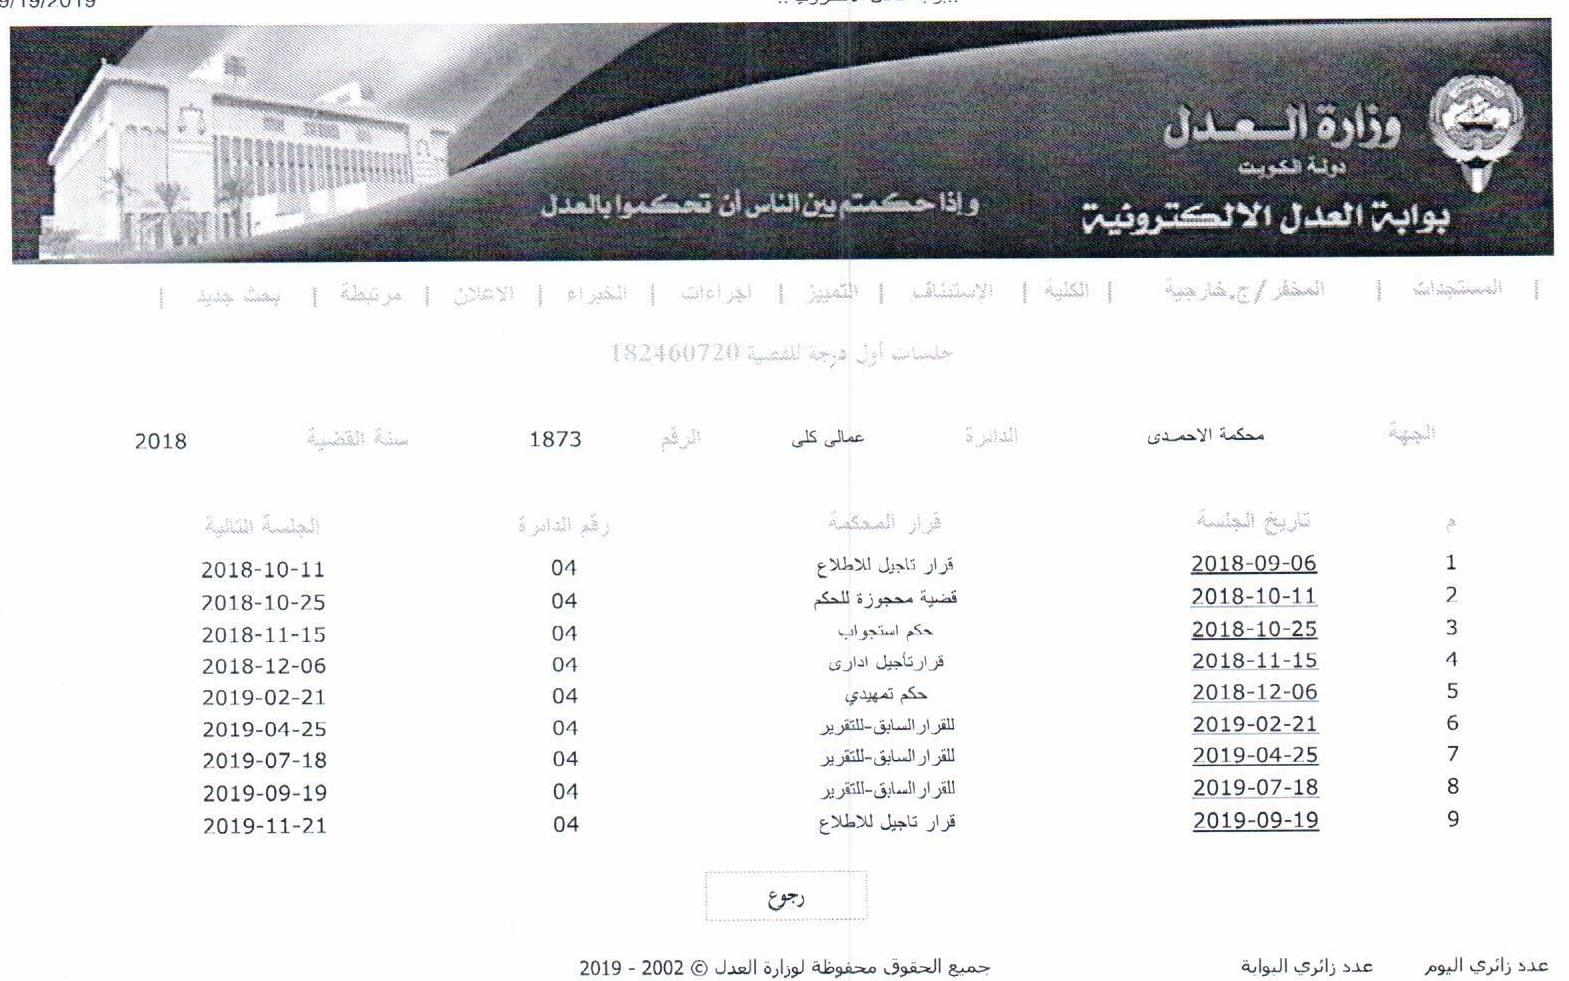
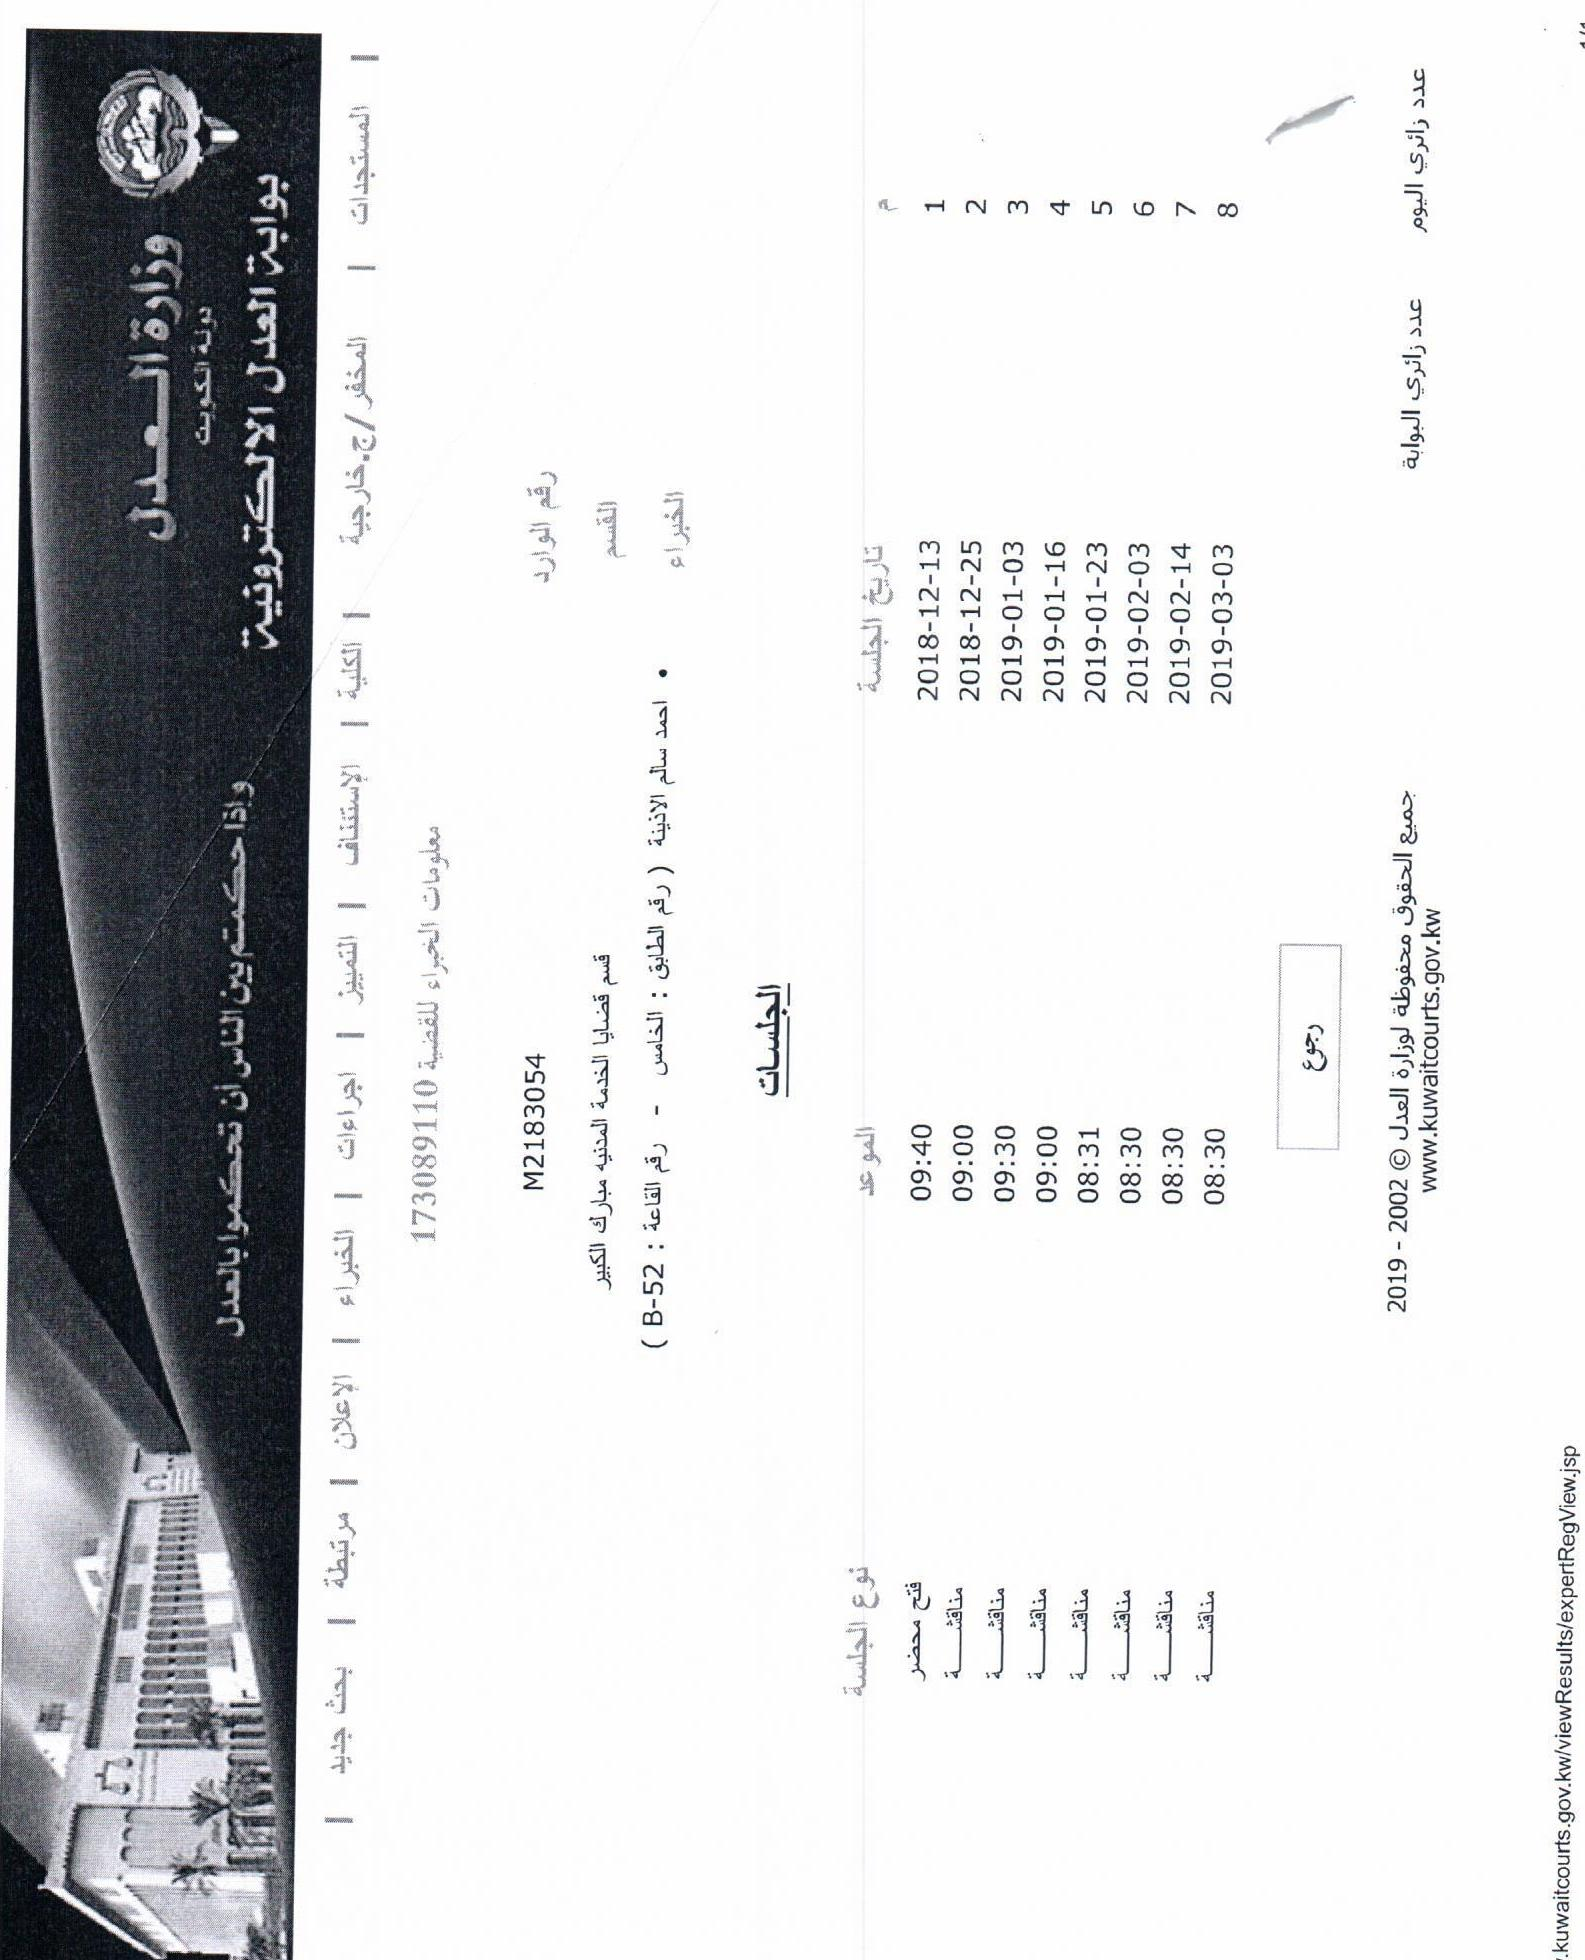
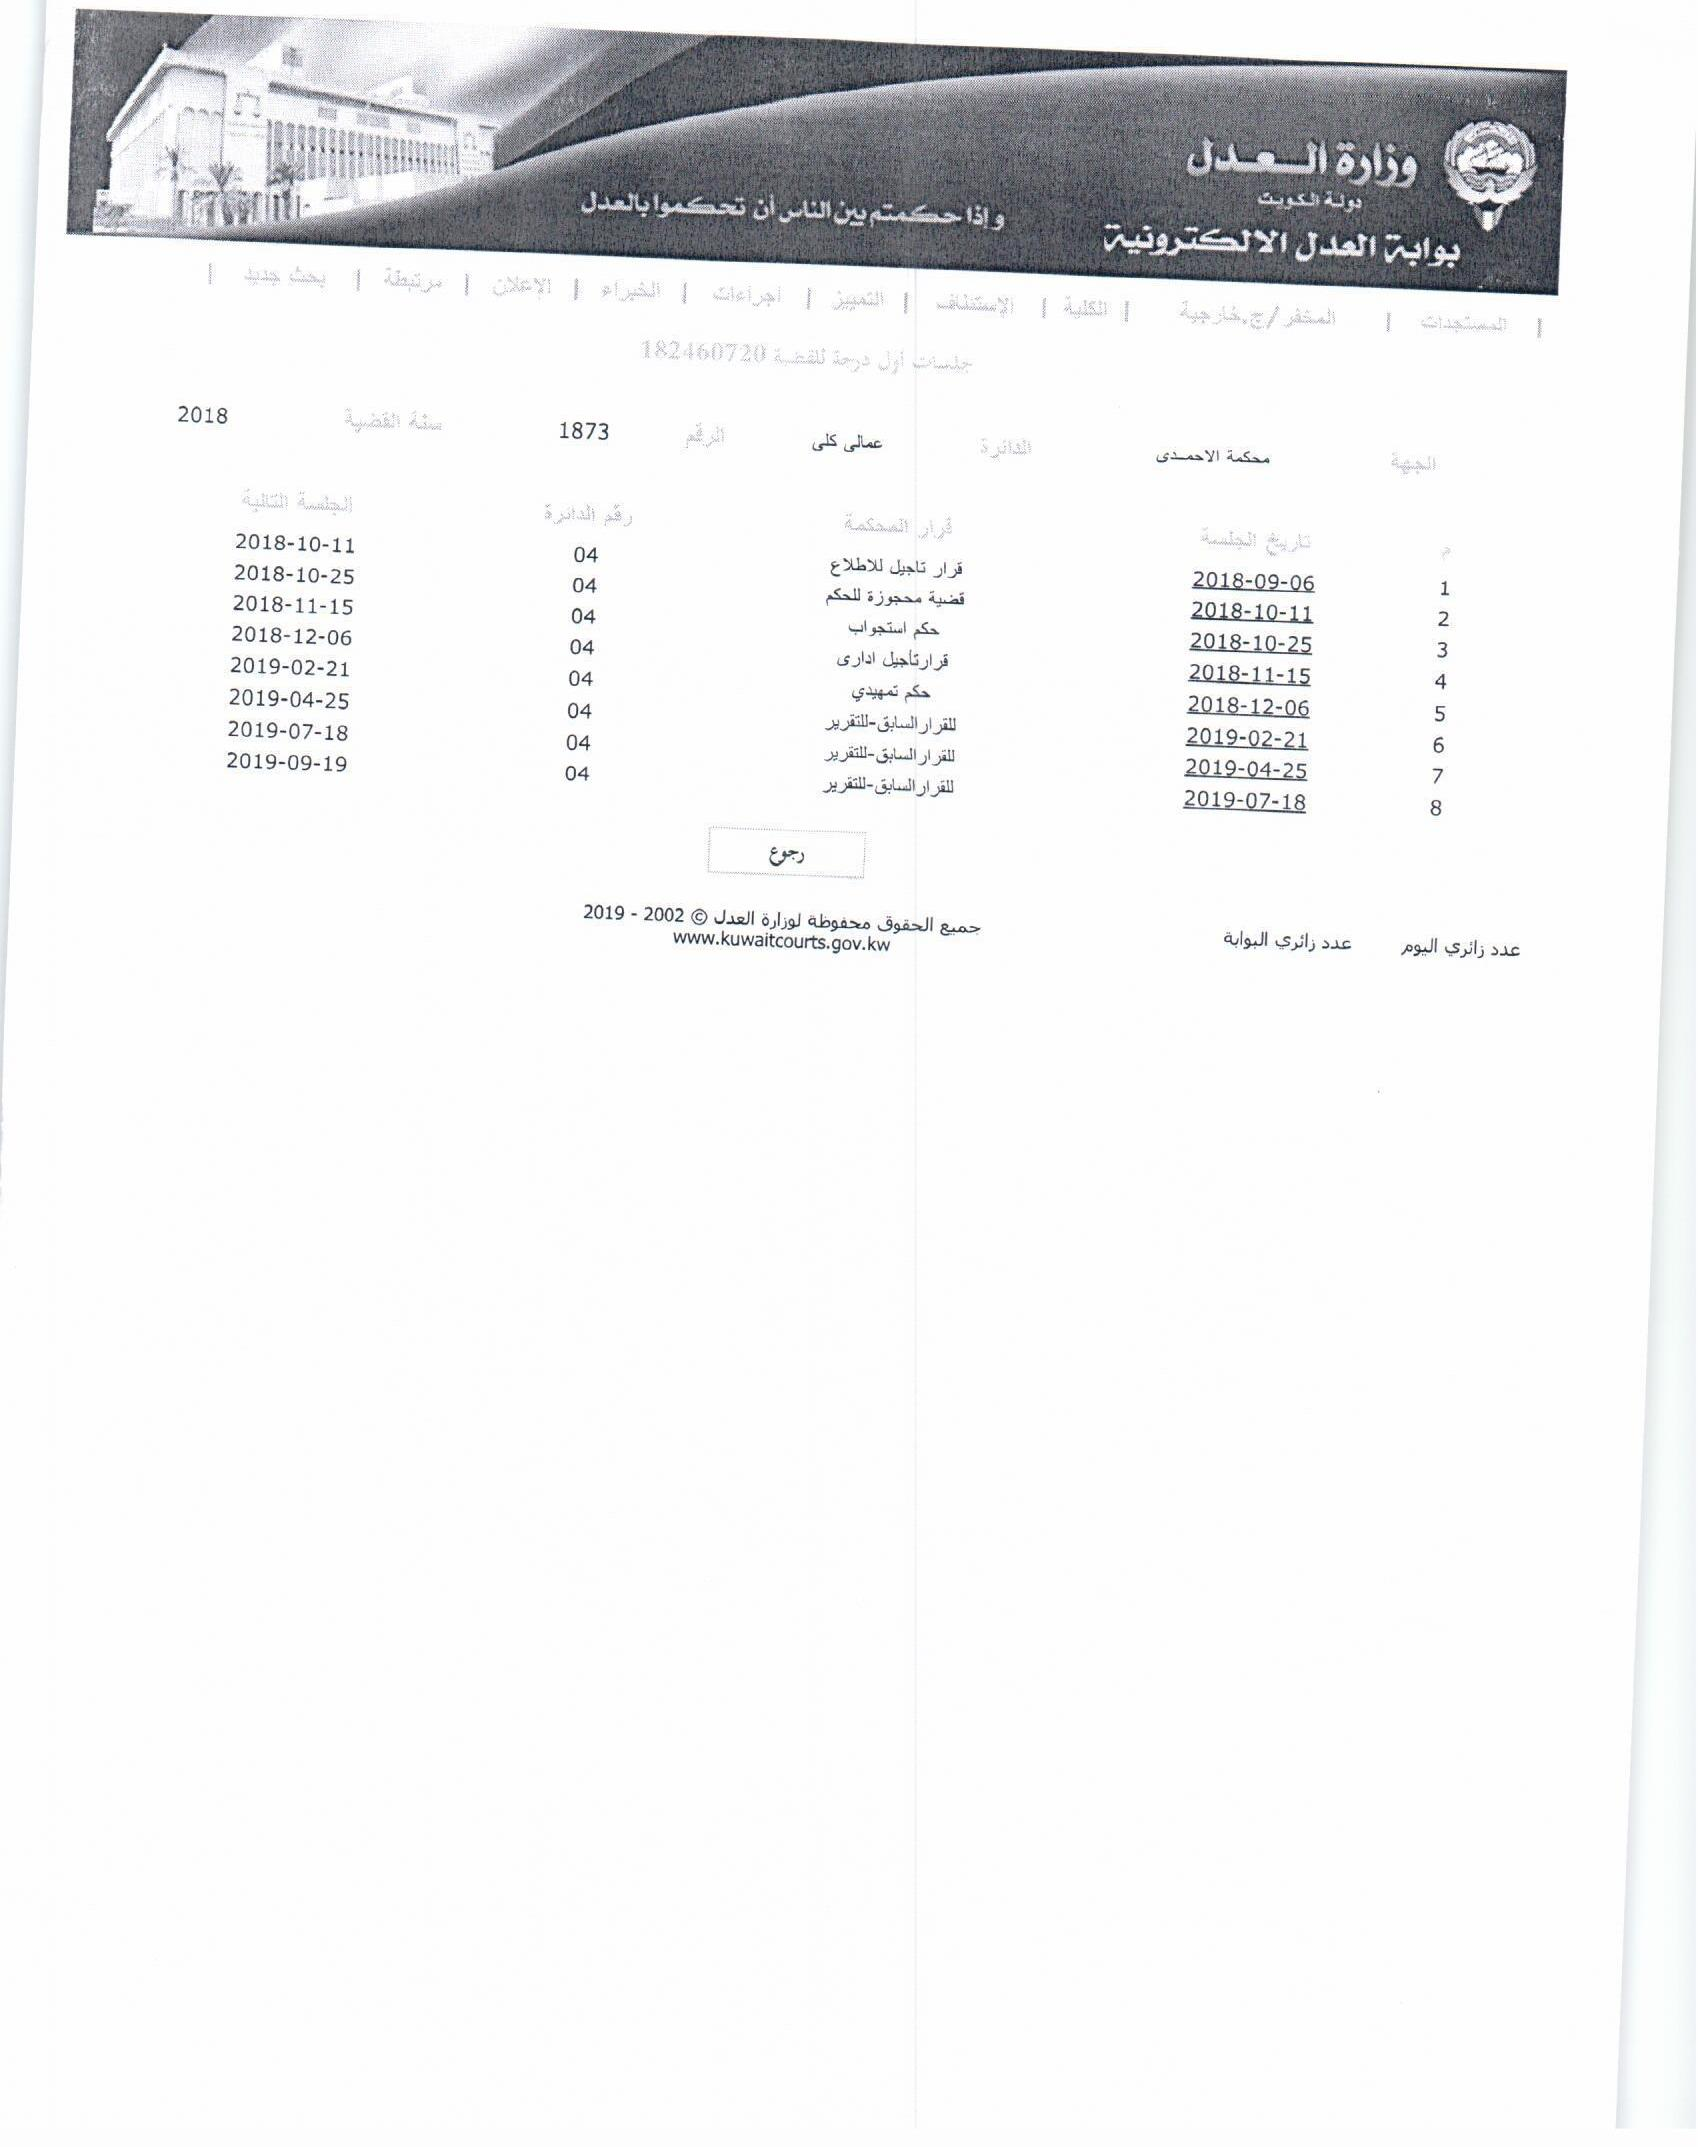
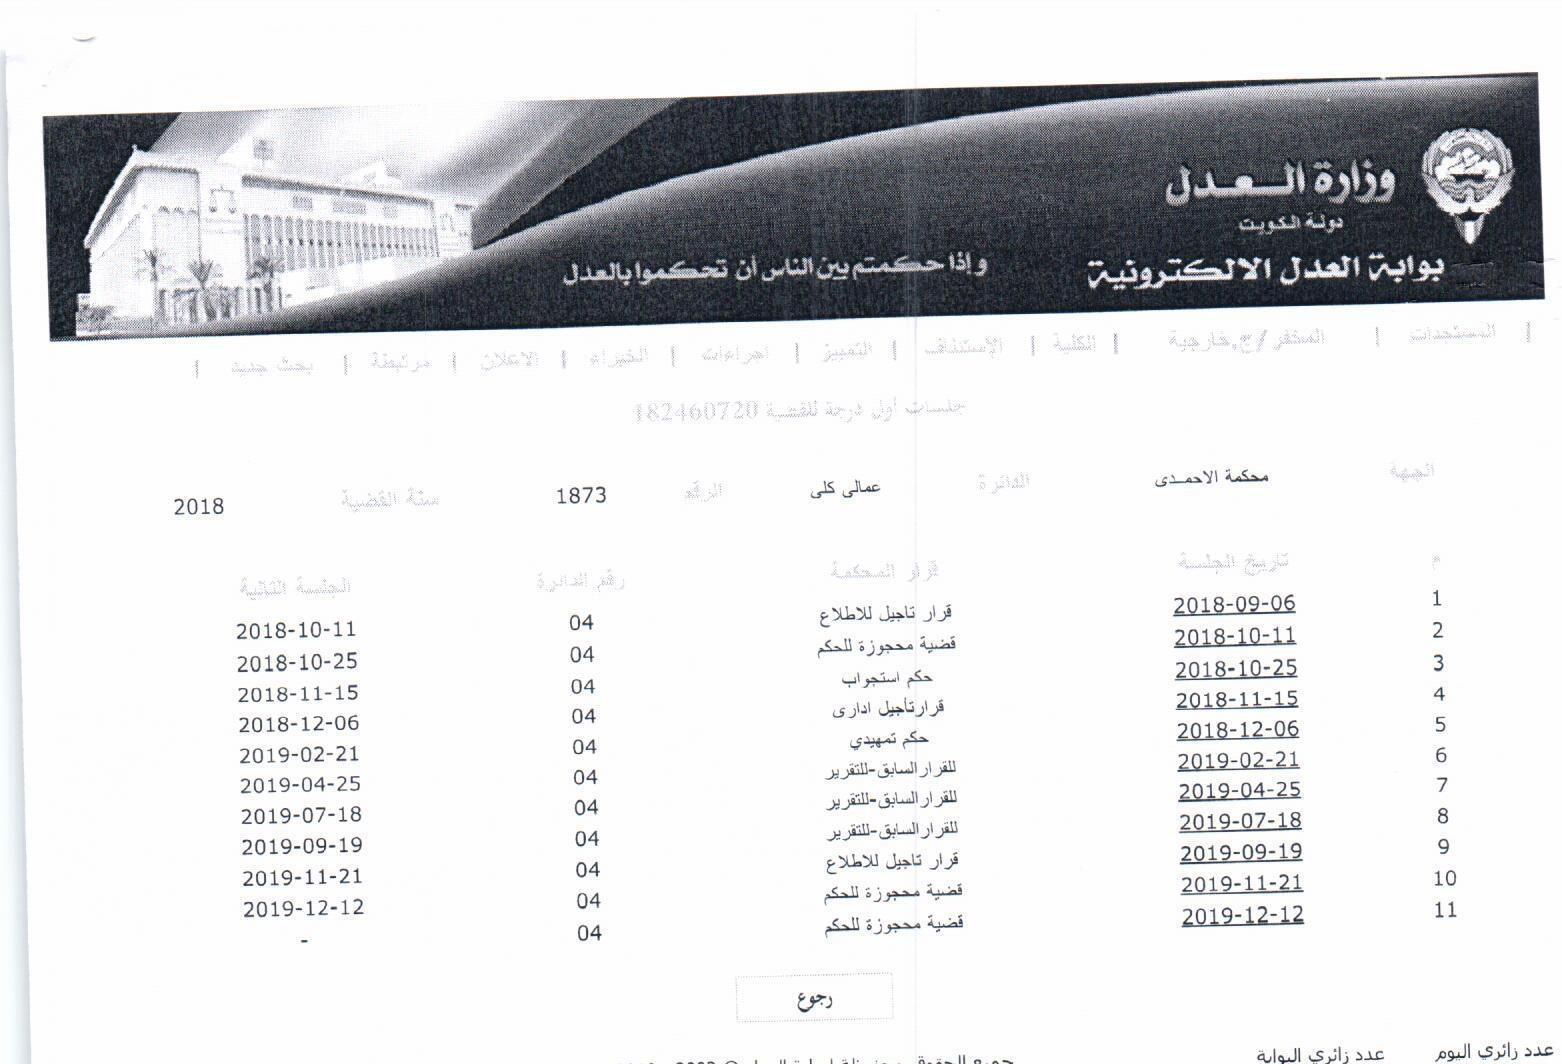
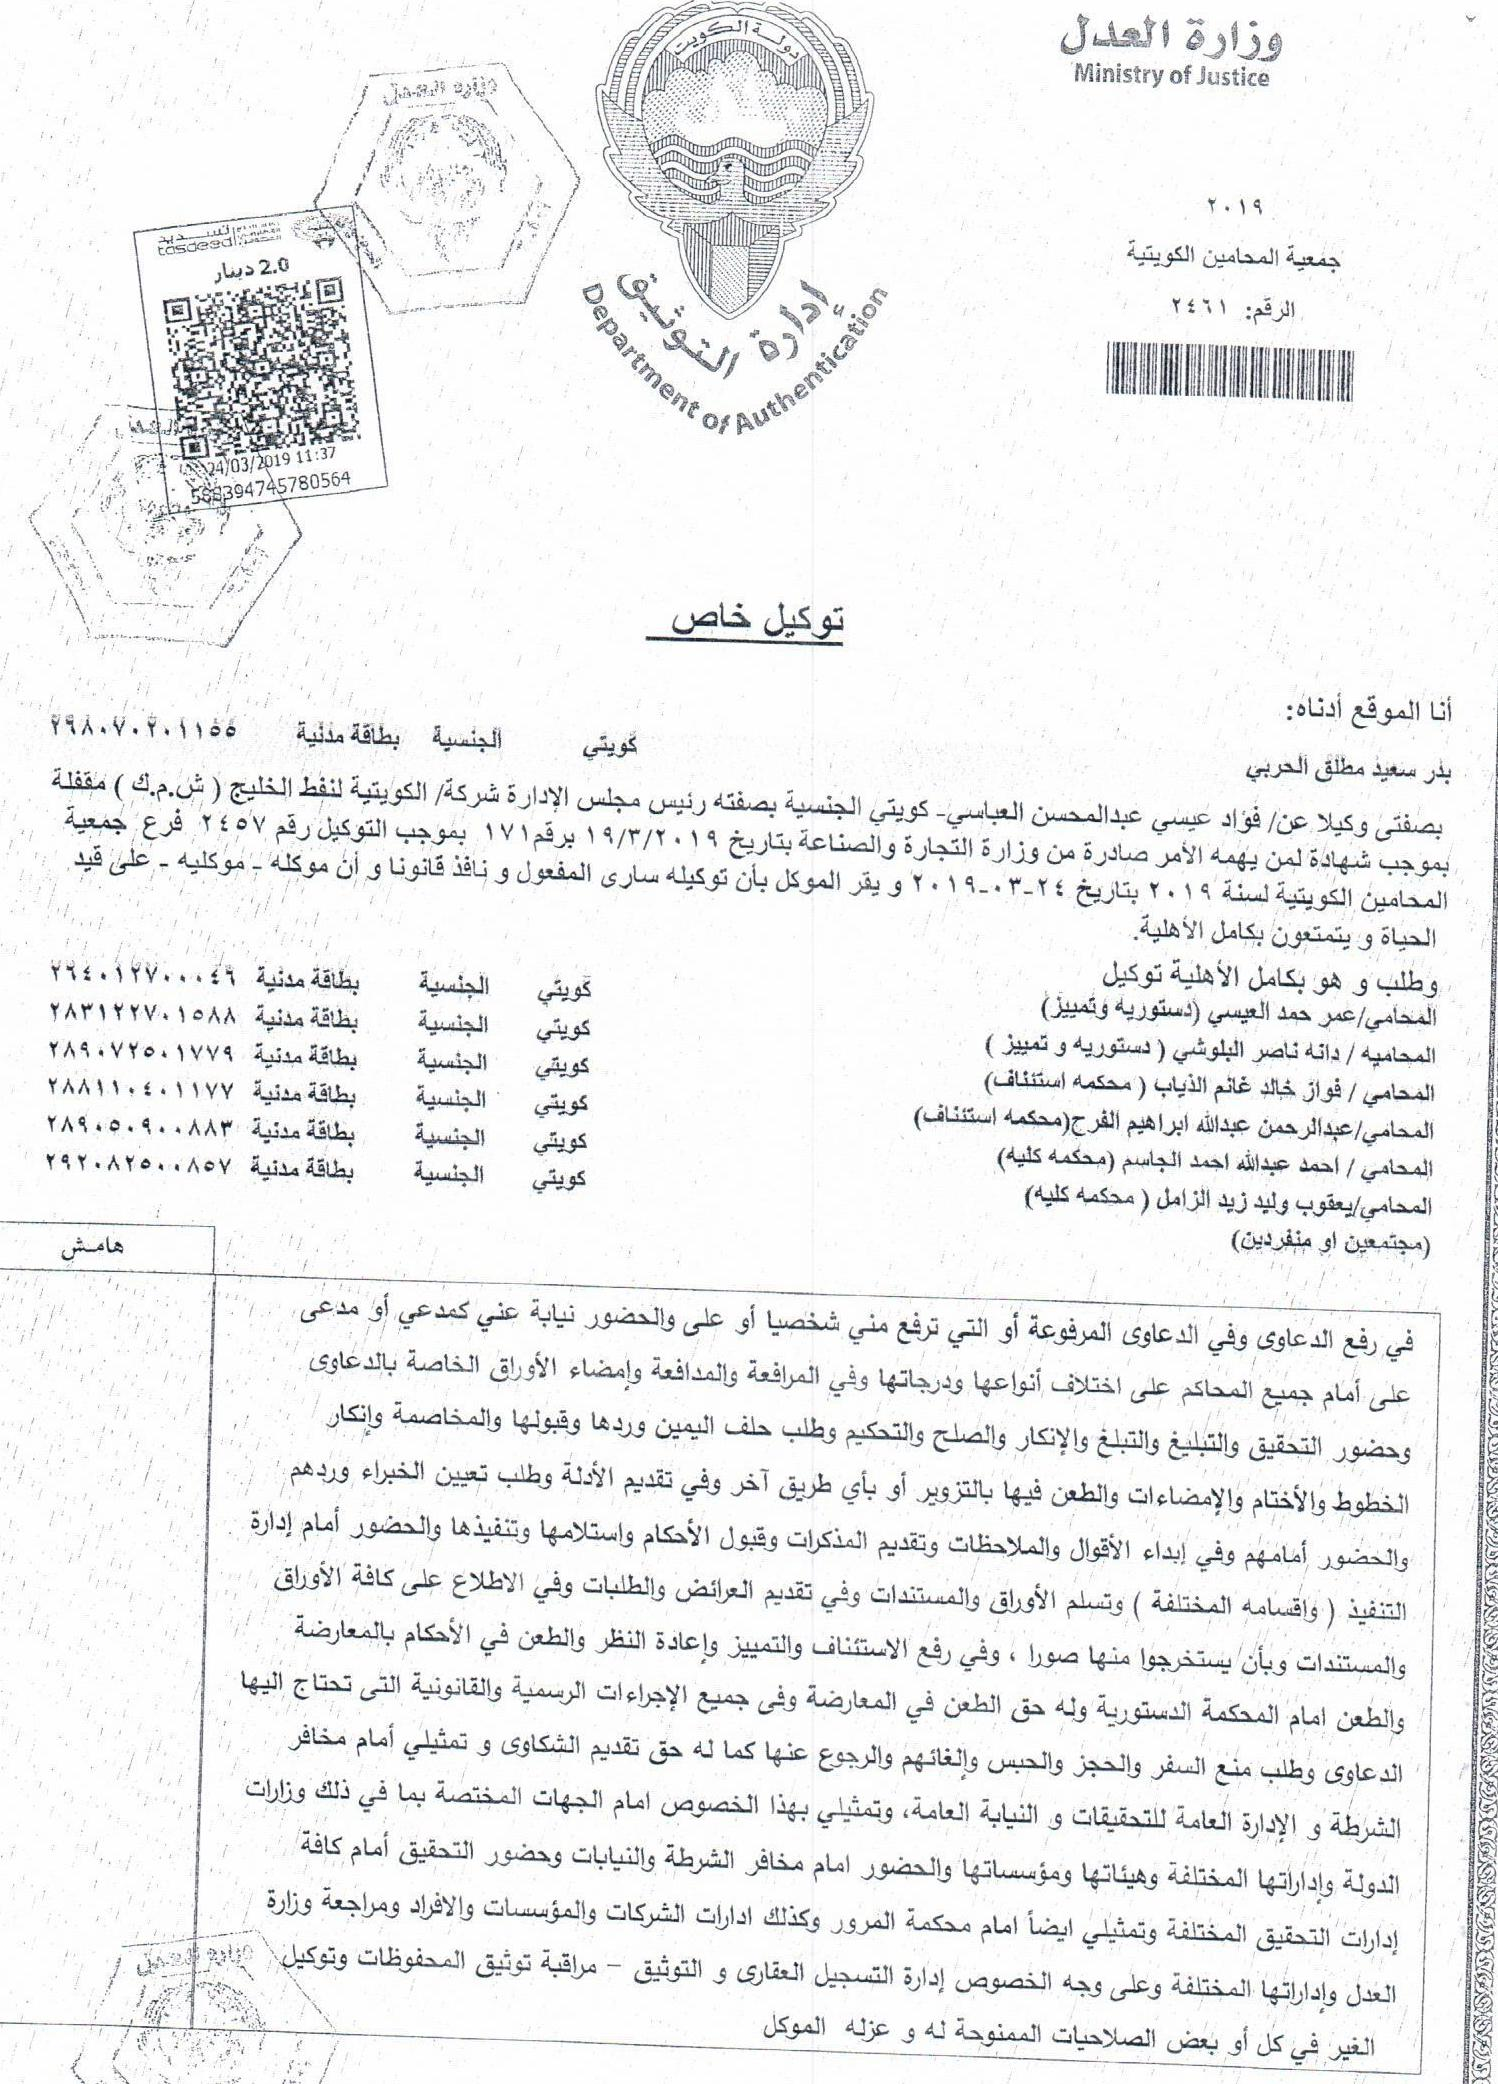
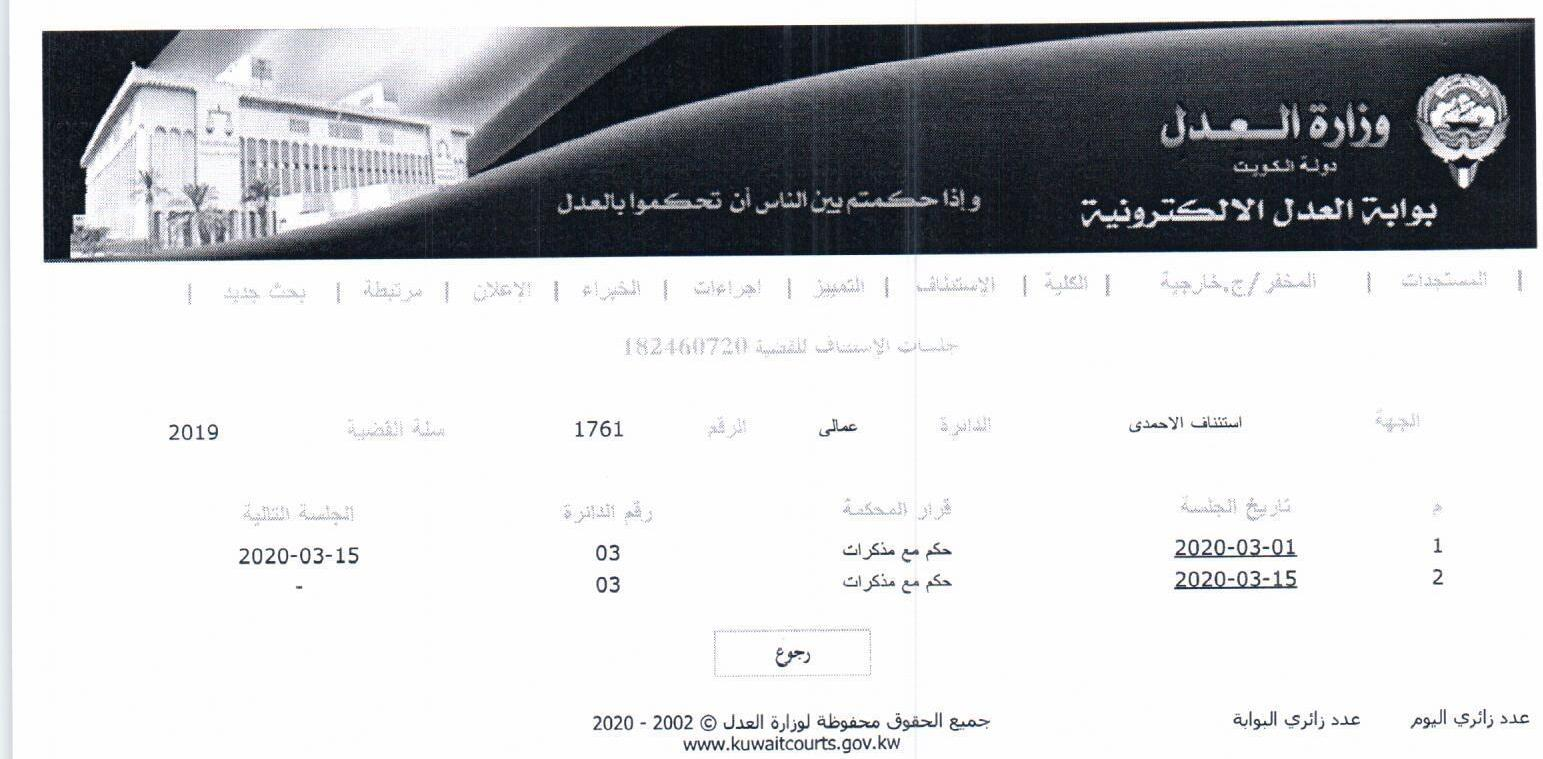
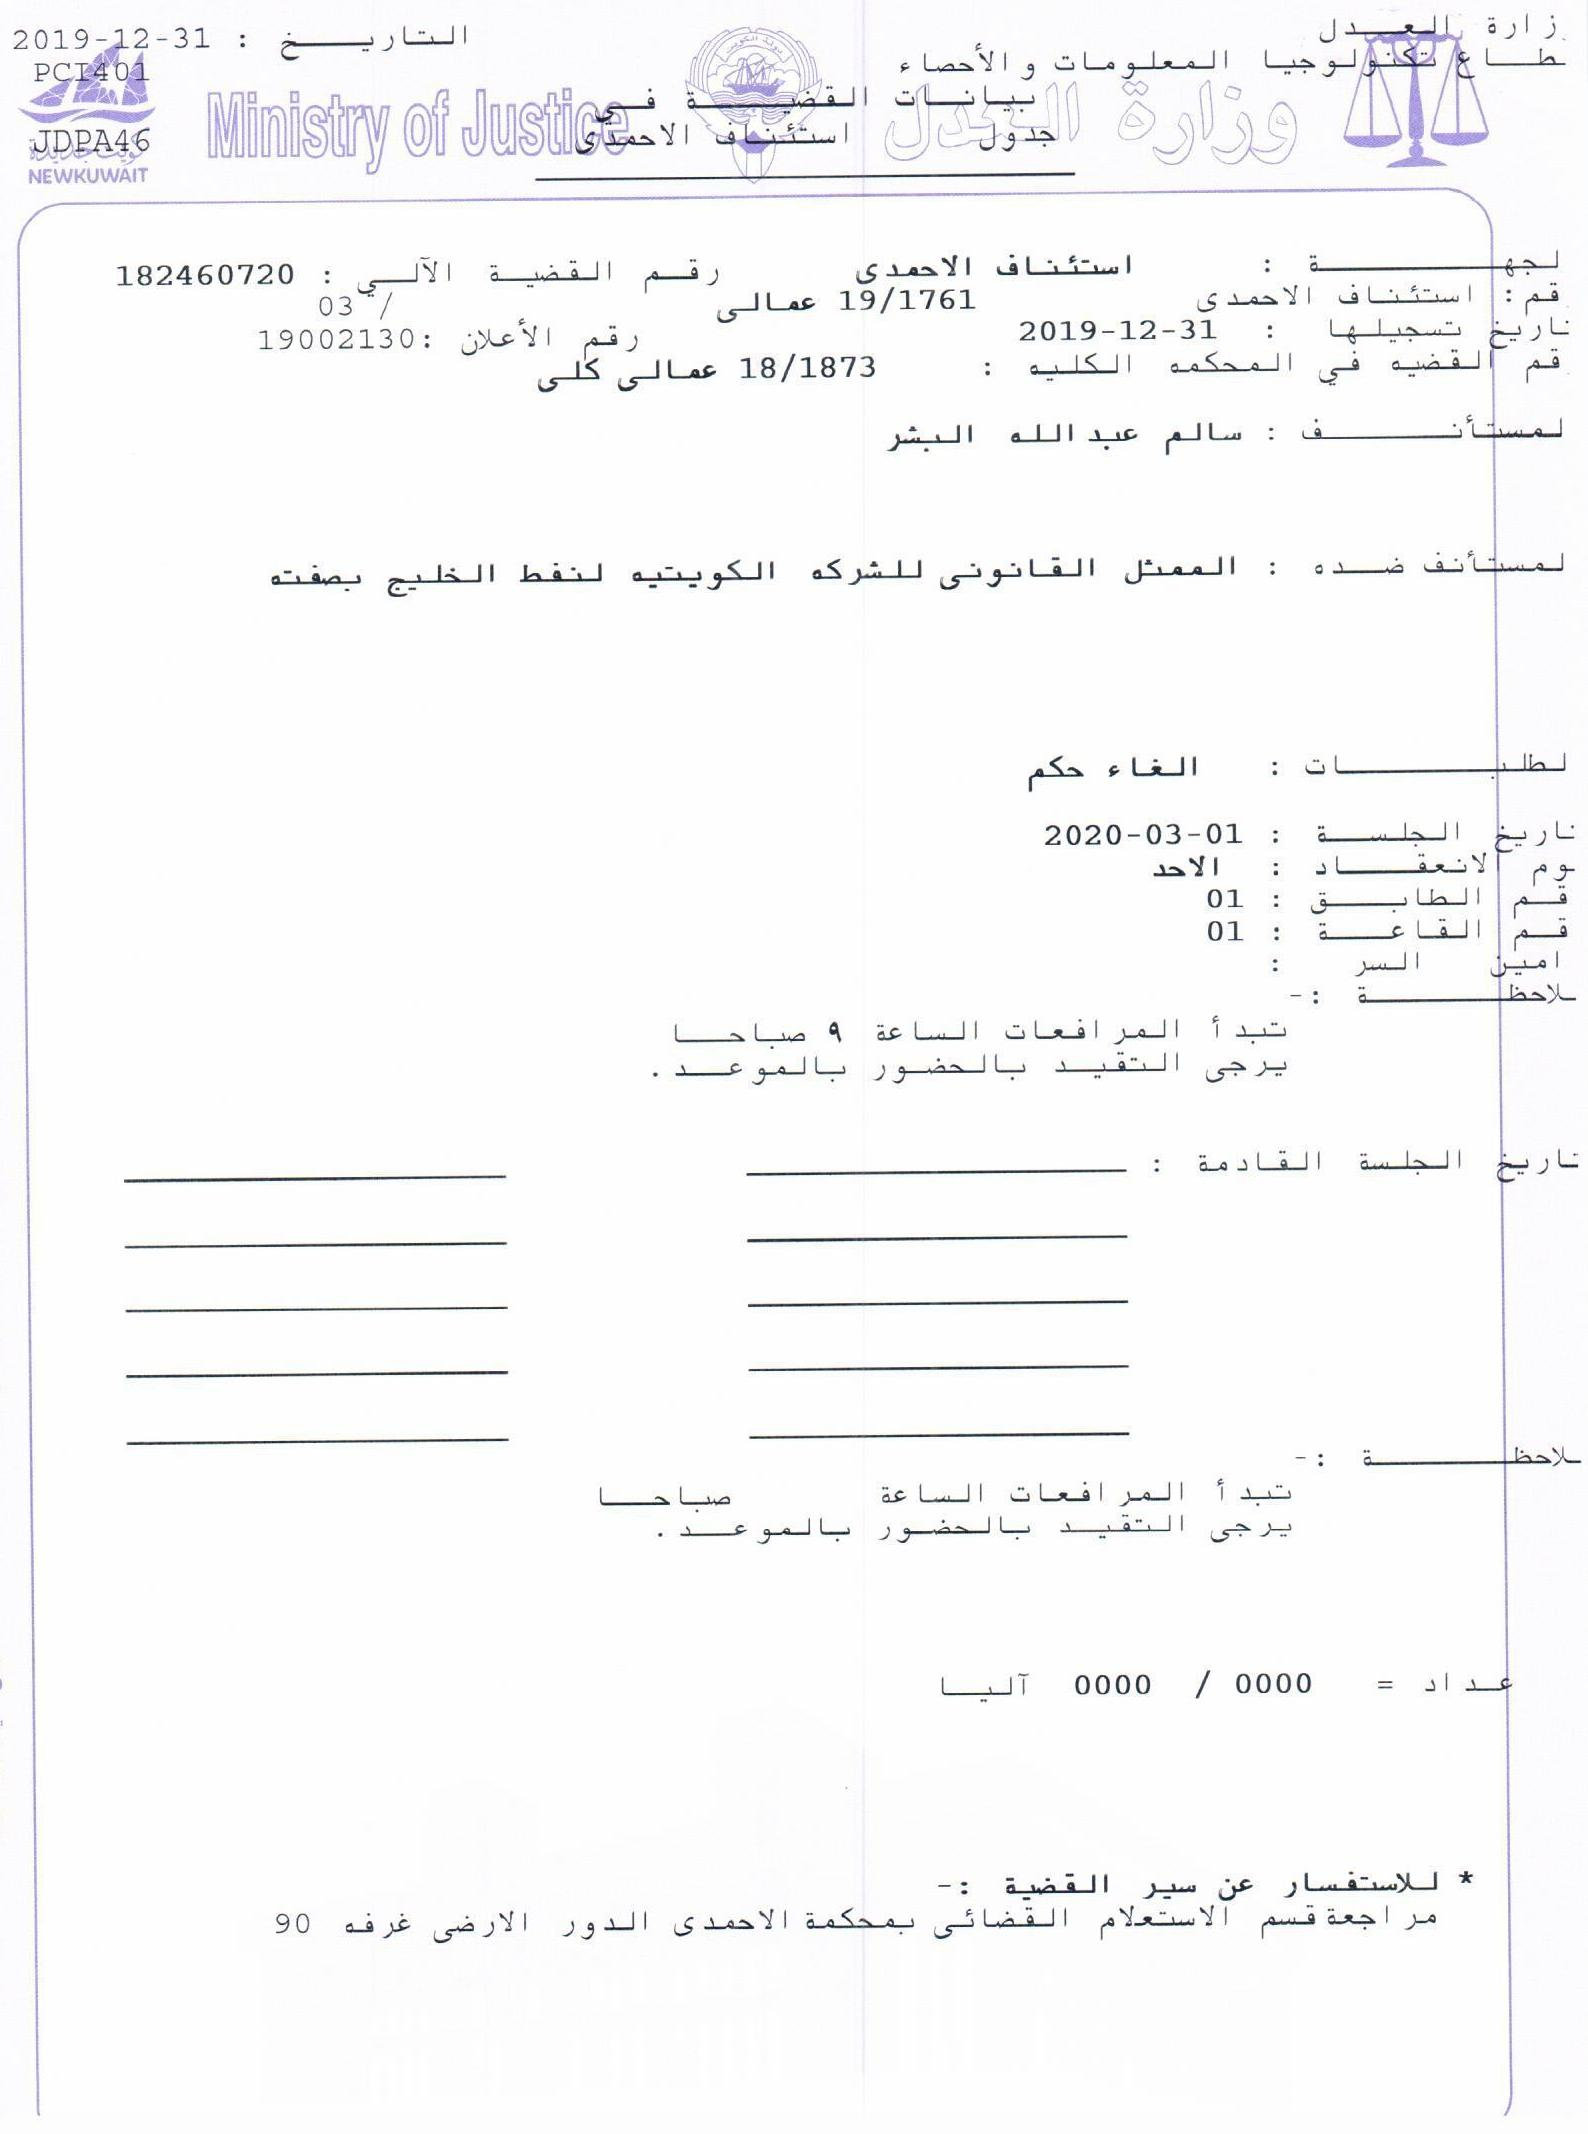

In [7]:
ocr_response.pages

In [ ]:
# Function to Chunk Text with Page Numbers
def chunk_text_with_pages(pages, chunk_size=500, chunk_overlap=50):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ".", " "]
    )
    chunks_with_pages = []
    for text, page_number in pages:
        chunks = text_splitter.split_text(text)
        for chunk in chunks:
            chunks_with_pages.append((chunk, page_number))
    return chunks_with_pages

# Create FAISS Index from Chunked Text
def create_faiss_index_from_text(chunks_with_pages):
    documents = [Document(page_content=chunk, metadata={"page_number": page}) for chunk, page in chunks_with_pages]
    embeddings = OpenAIEmbeddings(api_key="")
    faiss_index = FAISS.from_documents(documents, embeddings)
    return faiss_index

# RAG Pipeline with Page Numbers
def get_rag_response(query, vector_store):
    retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 1})
    qa_chain = RetrievalQA.from_chain_type(
        llm=ChatOpenAI(api_key="", model="gpt-4o-2024-11-20", temperature=0.001),
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True
    )
    result = qa_chain({"query": query})
    sources = set()
    if "source_documents" in result:
        sources = set(doc.metadata.get("page_number", "Unknown") for doc in result["source_documents"])
    return result.get("result", "No answer found."), sorted(sources)


In [ ]:
pages=oc

In [ ]:
chunks_with_pages = chunk_text_with_pages(pages)


In [ ]:
vector_store = create_faiss_index_from_text(chunks_with_pages)
